In [1]:
!rm -rf InkubaLM-Challenge
!git clone https://github.com/melissafasol/InkubaLM-Challenge.git
%cd InkubaLM-Challenge


Cloning into 'InkubaLM-Challenge'...
remote: Enumerating objects: 374, done.
remote: Counting objects: 100% (199/199), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 374 (delta 146), reused 121 (delta 86), pack-reused 175 (from 1)
Receiving objects: 100% (374/374), 1.41 MiB | 15.90 MiB/s, done.
Resolving deltas: 100% (245/245), done.
/content/InkubaLM-Challenge


In [2]:
%cd InkubaLM-Challenge
!git pull


[Errno 2] No such file or directory: 'InkubaLM-Challenge'
/content/InkubaLM-Challenge
Already up to date.


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
!pip install -U trl bitsandbytes
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [8]:
import sys
sys.path.append("..")  # Add parent directory to the path

import os
from typing import List
from pathlib import Path
import numpy as np

# DO NOT EDIT
# create submission file
import pandas as pd
from huggingface_hub import login
from transformers import (
    AutoTokenizer,
)
from utils import (
    eval,
    model_function,
    multitask,
    supplement,
    ab_testing
    )

import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset, concatenate_datasets, Dataset, Value
from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM
from peft import PeftModel

import shap

def build_prompt(example):
    return f"{example['instruction']}\n{example['inputs']}\nAnswer:"

def log_likelihood_score(prompt, label):
    full_input = prompt + " " + label
    input_ids = tokenizer(full_input, return_tensors="pt").input_ids.to("cuda")
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss
    return -loss.item()


def predict_fn(prompt_list):
    all_scores = []
    for prompt in prompt_list:
        scores = [log_likelihood_score(prompt, " " + label) for label in labels]
        probs = torch.nn.functional.softmax(torch.tensor(scores), dim=0)
        all_scores.append(probs.numpy())
    return all_scores

In [9]:
from google.colab import drive
drive.mount('/content/drive')
output_path = "/content/drive/MyDrive/InkubaLM-Challenge/Output"
os.makedirs(output_path, exist_ok=True)

Mounted at /content/drive


In [10]:
#os.environ["TOKENIZERS_PARALLELISM"] = "false"

from huggingface_hub import login

try:
    from google.colab import userdata

    # Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
    # vars as appropriate for your system.
    # userdata.get("HF_TOKEN") indicates that the name of the token in the Colab env is HF_TOKEN
    os.environ["hf_token_2"] = userdata.get("hf_token_2")
except:
    os.environ["hf_token_2"] = "----"

login(token=os.environ["hf_token_2"])

token = os.environ["hf_token_2"]
if token == "----":
    print("⚠️ Warning: No Hugging Face token found. Some models may not load.")
else:
    login(token=token)

In [11]:
import pickle
import os

# Define the directory path
save_dir = "/content/drive/MyDrive/InkubaLM/outputs"

# Define file paths
explainer_path = os.path.join(save_dir, "explainer.pkl")
shap_values_path = os.path.join(save_dir, "shap_values.pkl")

# Check file sizes (should be > 0)
print("Explainer file size:", os.path.getsize(explainer_path))
print("SHAP values file size:", os.path.getsize(shap_values_path))

# Try loading the files
try:
    with open(explainer_path, "rb") as f:
        loaded_explainer = pickle.load(f)
    print("✅ Explainer loaded successfully.")
except Exception as e:
    print("❌ Error loading explainer:", e)

try:
    with open(shap_values_path, "rb") as f:
        loaded_shap_values = pickle.load(f)
    print("✅ SHAP values loaded successfully.")
except Exception as e:
    print("❌ Error loading SHAP values:", e)


Explainer file size: 4356091
SHAP values file size: 5759468
✅ Explainer loaded successfully.
✅ SHAP values loaded successfully.


In [12]:
type(loaded_shap_values)

shap._explanation.Explanation

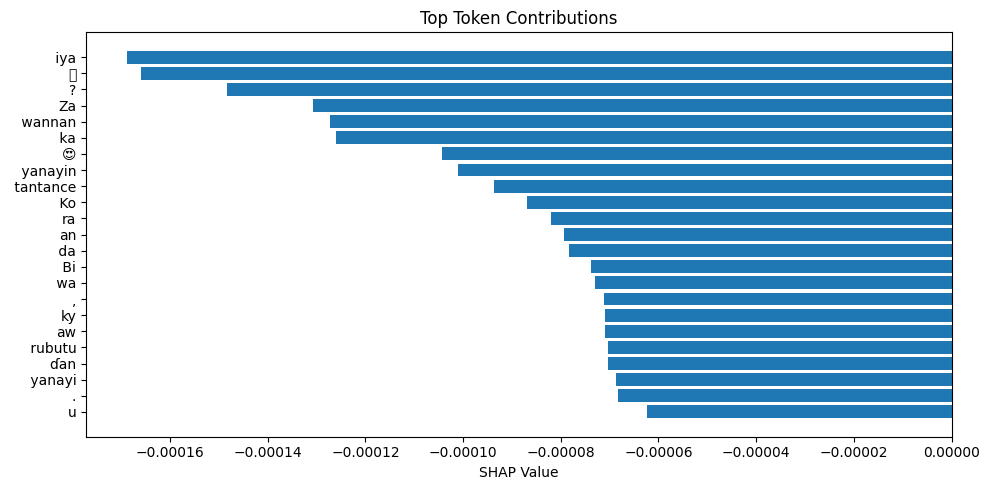

In [14]:
import matplotlib.pyplot as plt

# Pick example
example = loaded_shap_values[0]

# Extract tokens and SHAP values
tokens = example.data
shap_vals = example.values

# If multi-output (e.g., XNLI), select just one class
if isinstance(shap_vals[0], (list, np.ndarray)):
    shap_vals = [v[0] for v in shap_vals]  # or change index as needed

# Convert to pandas for easier sorting
import pandas as pd
df = pd.DataFrame({
    "token": tokens,
    "shap_value": shap_vals
})

# Sort by absolute contribution
df = df.reindex(df["shap_value"].abs().sort_values(ascending=False).index)

# Plot top 15 contributors
plt.figure(figsize=(10, 5))
plt.barh(df["token"][:30], df["shap_value"][:30])
plt.gca().invert_yaxis()
plt.xlabel("SHAP Value")
plt.title("Top Token Contributions")
plt.tight_layout()
plt.show()


In [15]:
print("# Loading datasets")
se_dataset, mt_dataset,xn_dataset = multitask.load_and_combine_datasets("Train")
test_dataset = multitask.load_and_combine_datasets("Test")


test_dataset_list = list(test_dataset)
combined_test_dataset = concatenate_datasets(test_dataset_list)


# Loading datasets


README.md:   0%|          | 0.00/485 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/39.0k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/400 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/485 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/72.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/600 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/447 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/35.0k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/400 [00:00<?, ? examples/s]

All Columns: ['premise', 'targets', 'task', 'instruction', 'data_source', 'langs', 'ID', 'inputs']


Casting the dataset:   0%|          | 0/400 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/600 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/400 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/486 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/33.1k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/300 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/484 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/22.4k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/300 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/447 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/28.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/300 [00:00<?, ? examples/s]

All Columns: ['premise', 'targets', 'task', 'instruction', 'data_source', 'langs', 'ID', 'inputs']


Casting the dataset:   0%|          | 0/300 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/300 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/300 [00:00<?, ? examples/s]

## Load Base Model and Fine-Tuned QLoRA model

## Base Model:

In [20]:
model_name = "lelapa/InkubaLM-0.4B"
model, tokenizer, bnb_config = multitask.setup_model_and_tokenizer(model_name, token=token,use_4bit=False)

config.json:   0%|          | 0.00/763 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.66G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/960 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/991k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.95M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [21]:
prompt = "Translate to Swahili: I love science."

inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
outputs = model.generate(**inputs, max_new_tokens=20)

print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Translate to Swahili: I love science. Translate to Swahili: I love science. Translate to Swahili: I love science.


### QLoRA Model

In [22]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model = AutoModelForCausalLM.from_pretrained("melissafasol/Inkuba_QLoRA", device_map="auto")
tokenizer = AutoTokenizer.from_pretrained("melissafasol/Inkuba_QLoRA")



In [19]:
prompt = "Translate to Swahili: I love science."

inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
outputs = model.generate(**inputs, max_new_tokens=20)

print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Translate to Swahili: I love science. | Apg29 Translate to Swahili: I love science. | Apg29 Trans


### Code to implement SHAP analysis on base model

In [29]:
#Separate by language
se_df = pd.DataFrame(se_dataset)
xn_df = pd.DataFrame(xn_dataset)



In [36]:
swa_se = se_df.loc[se_df['langs'] == 'swahili']
hau_se = se_df.loc[se_df['langs'] == 'hausa']
swa_xn = se_df.loc[xn_df['langs'] == 'swahili']
hau_xn = se_df.loc[xn_df['langs'] == 'hausa']

swa_se_dset = Dataset.from_pandas(swa_se)
hau_se_dset = Dataset.from_pandas(hau_se)
swa_xn_dset = Dataset.from_pandas(swa_xn)
hau_xn_dset = Dataset.from_pandas(hau_xn)

In [37]:
labels = swa_se_dset['targets']
sample_data = swa_se_dset.select(range(3))
sample_prompts = [build_prompt(example) for example in sample_data]

In [38]:
model.to("cuda")

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(61788, 2048)
    (layers): ModuleList(
      (0-7): 8 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (v_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (up_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (down_proj): Linear(in_features=5632, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
    (rotary_emb): 

In [39]:
def build_prompt(example):
    return f"{example['instruction']}\n{example['inputs']}\nAnswer:"

def log_likelihood_score(prompt, label):
    full_input = prompt + " " + label
    input_ids = tokenizer(full_input, return_tensors="pt").input_ids.to("cuda")
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss
    return -loss.item()


def predict_fn(prompt_list):
    all_scores = []
    for prompt in prompt_list:
        scores = [log_likelihood_score(prompt, " " + label) for label in labels]
        probs = torch.nn.functional.softmax(torch.tensor(scores), dim=0)
        all_scores.append(probs.numpy())
    return all_scores


In [40]:
explainer = shap.Explainer(predict_fn, tokenizer, algorithm = "partition")
shap_values = explainer(sample_prompts)

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 1/3 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 3/3 [1:20:22<00:00, 1197.75s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 4it [2:00:18, 2406.31s/it]


In [41]:
import os
import pickle

# Define save path
save_dir = "/content/drive/MyDrive/InkubaLM/outputs/swahili_sentiment"
os.makedirs(save_dir, exist_ok=True)

# Recreate explainer and generate SHAP values
explainer = shap.Explainer(predict_fn, tokenizer, algorithm="partition")
shap_values = explainer(sample_prompts)

# Save explainer
with open(os.path.join(save_dir, "explainer.pkl"), "wb") as f:
    pickle.dump(explainer, f)

# Save shap values
with open(os.path.join(save_dir, "shap_values.pkl"), "wb") as f:
    pickle.dump(shap_values, f)

print("✅ SHAP values and explainer saved successfully.")


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 1/3 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 3/3 [1:20:22<00:00, 1195.53s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 4it [2:00:13, 2404.37s/it]

✅ SHAP values and explainer saved successfully.


In [42]:
labels = hau_se_dset ['targets']
sample_data = hau_se_dset.select(range(3))
sample_prompts = [build_prompt(example) for example in sample_data]

In [43]:
explainer = shap.Explainer(predict_fn, tokenizer, algorithm = "partition")
shap_values = explainer(sample_prompts)

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 1/3 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 3/3 [1:18:00<00:00, 2340.44s/it]


KeyboardInterrupt: 

In [ ]:
# Define save path
save_dir = "/content/drive/MyDrive/InkubaLM/outputs/hausa_sentiment"
os.makedirs(save_dir, exist_ok=True)

# Save explainer
with open(os.path.join(save_dir, "explainer.pkl"), "wb") as f:
    pickle.dump(explainer, f)

# Save shap values
with open(os.path.join(save_dir, "shap_values.pkl"), "wb") as f:
    pickle.dump(shap_values, f)

print("✅ SHAP values and explainer saved successfully.")


In [ ]:
# Plot SHAP for one example
shap.plots.text(shap_values[0])

In [ ]:
import os

adapter_path = "/content/drive/MyDrive/InkubaLM/outputs/sft_model/balanced/lora_adapter_v4"
print(os.listdir(adapter_path))


['config.json', 'generation_config.json', 'tokenizer_config.json', 'special_tokens_map.json', 'tokenizer.model', 'tokenizer.json']


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    "/content/drive/MyDrive/InkubaLM/outputs/lora_checkpoint"
)
tokenizer.pad_token = tokenizer.eos_token  # Important for generation

# 2. Load LoRA adapter on top of base model
model = PeftModel.from_pretrained(
    base_model,
    "/content/drive/MyDrive/InkubaLM/outputs/lora_checkpoint"
)

model.eval()

In [25]:
print("# Loading datasets")
train_dataset = multitask.load_and_combine_datasets("Train")
test_dataset = multitask.load_and_combine_datasets("Test")

print("\n# Example from training dataset:")
print(train_dataset[0])

print("\n# Example from test dataset:")
print(test_dataset[0])

# Loading datasets
All Columns: ['premise', 'targets', 'task', 'instruction', 'data_source', 'langs', 'ID', 'inputs']
All Columns: ['premise', 'targets', 'task', 'instruction', 'data_source', 'langs', 'ID', 'inputs']

# Example from training dataset:
Dataset({
    features: ['ID', 'task', 'langs', 'data_source', 'instruction', 'inputs', 'targets', 'premise'],
    num_rows: 400
})

# Example from test dataset:
Dataset({
    features: ['ID', 'task', 'langs', 'data_source', 'instruction', 'inputs', 'targets', 'premise'],
    num_rows: 300
})


In [26]:
model.eval()

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(61788, 2048)
    (layers): ModuleList(
      (0-7): 8 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (v_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (up_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (down_proj): Linear(in_features=5632, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
    (rotary_emb): 

## Evaluate the Current Model

Run inference analysis on the test set to measure how well the model generalises on unseen data:

In [27]:
results_df = multitask.apply_inference_to_test_data(model, tokenizer, test_dataset)
results_df.to_csv("submission_balanced_qlora.csv", index=False)


Generating Responses:   0%|          | 0/3 [00:00<?, ?it/s]

KeyError: 'premise'

In [ ]:
results_df.head()

,ID,langs,instruction,inputs,targets,generated,Response
0,ID_f3c74c7b_sentiment_test__hausa,hausa,Gano ra'ayin da aka bayyana a cikin wannan rub...,@user ynxu fha da kanada kudi shikenan duk kay...,None,Kyakkyawan Hoto na Hoto na Hoto na Hoto na Hot...,0
1,ID_aad19dbf_sentiment_test__hausa,hausa,Za ka iya tantance yanayin wannan rubutu? Bi w...,@user alhamdulillah babu abinda zamuce sai god...,None,Korau Kasashen Duniya Da Kasashen Duniya Da Ka...,2
2,ID_f6de0381_sentiment_test__hausa,hausa,Za ka iya tantance yanayin wannan rubutu? Bi w...,@user ke ina ruwan ki 😬 ba harkar film bane ba,None,Korau: idan rubutu na nuna kyakkyawar magana k...,0
3,ID_cbec84fe_sentiment_test__swahili,swahili,Changanua mawazo ya matini yanayofuata na uain...,matokeo chanya liverais magufuli katika uzindu...,None,Wastani Wastani Wastani Wastani Wastani Wastan...,1
4,ID_885caf5c_sentiment_test__hausa,hausa,Tantance ra’ayin wannan rubutu kuma a rarraba ...,@user 🤣 akwai lauje cikin nadi gaskiya.,None,Korau Korau Korau Korau Korau Korau Kora,2


**The response column shows raw generated outputs that:**
- mix classification, translation and nonsense
- often repeat words
- sometimes echoes the prompt

**1. Identify Task Type from ID**

In [28]:
def get_task_type(row):
    if "sentiment" in row["ID"]:
        return "sentiment"
    elif "xnli" in row["ID"]:
        return "nli"
    elif "mt" in row["ID"]:
        return "mt"
    else:
        return "unknown"

results_df["task"] = results_df.apply(get_task_type, axis=1)


NameError: name 'results_df' is not defined

In [ ]:
results_df

,ID,langs,instruction,inputs,targets,generated,Response,task
0,ID_f3c74c7b_sentiment_test__hausa,hausa,Gano ra'ayin da aka bayyana a cikin wannan rub...,@user ynxu fha da kanada kudi shikenan duk kay...,None,Kyakkyawan Hoto na Hoto na Hoto na Hoto na Hot...,0,sentiment
1,ID_aad19dbf_sentiment_test__hausa,hausa,Za ka iya tantance yanayin wannan rubutu? Bi w...,@user alhamdulillah babu abinda zamuce sai god...,None,Korau Kasashen Duniya Da Kasashen Duniya Da Ka...,2,sentiment
2,ID_f6de0381_sentiment_test__hausa,hausa,Za ka iya tantance yanayin wannan rubutu? Bi w...,@user ke ina ruwan ki 😬 ba harkar film bane ba,None,Korau: idan rubutu na nuna kyakkyawar magana k...,0,sentiment
3,ID_cbec84fe_sentiment_test__swahili,swahili,Changanua mawazo ya matini yanayofuata na uain...,matokeo chanya liverais magufuli katika uzindu...,None,Wastani Wastani Wastani Wastani Wastani Wastan...,1,sentiment
4,ID_885caf5c_sentiment_test__hausa,hausa,Tantance ra’ayin wannan rubutu kuma a rarraba ...,@user 🤣 akwai lauje cikin nadi gaskiya.,None,Korau Korau Korau Korau Korau Korau Kora,2,sentiment
...,...,...,...,...,...,...,...,...
895,ID_88cd08fe_test__afrixnli_hau,hau,"Is the following question True, False or Neither?",Bradley ya fito daga Missouri.,None,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0,0,nli
896,ID_404bc9af_test__afrixnli_swa,swa,"Is the following question True, False or Neither?",Brahma ni sehemu muhimu zaidi ya utatu.,None,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0,0,nli
897,ID_a399ed32_test__afrixnli_swa,swa,"Is the following question True, False or Neither?",Ilinichukua muda wa miezi 13 kukiweka kichemsh...,None,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0,0,nli
898,ID_9f28a032_test__afrixnli_hau,hau,"Is the following question True, False or Neither?",an hada da nazarin Marxist-Leninist a harkar k...,None,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1,1,nli


**2. Plot lengths of generated outputs**
- repetitive translations
- long hallucinated outputs
- tasks with very short generations (like sentiment)

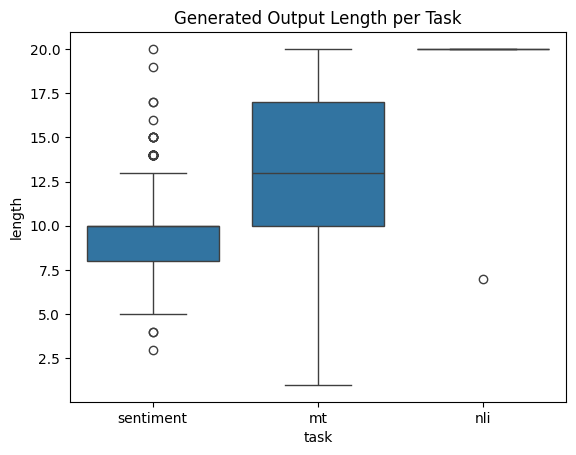

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

results_df["length"] = results_df["generated"].str.split().apply(len)

sns.boxplot(data=results_df, x="task", y="length")
plt.title("Generated Output Length per Task")
plt.show()



**3. Check for repetitive or low-quality outputs**
- model instability or overtraining

In [ ]:
repetitive = results_df[results_df["generated"].str.contains(r"\b(\w+)( \1\b){3,}", regex=True, na=False)]
print(f"Repetitive outputs: {len(repetitive)} / {len(results_df)}")



Repetitive outputs: 583 / 900


In [ ]:
repetitive[["task", "inputs", "generated"]].sample(5)


,task,inputs,generated
279,sentiment,@user allah ya kiyaye wannan ba fata bane....😒...,Korau Korau Korau Korau Korau Korau Kora
880,nli,rukunin tushe yafi farashin.,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
297,sentiment,erikali imesema imedhamiria kuwanufaisha wanan...,Wastani Wastani Wastani Wastani Wastani Wastan...
44,sentiment,tafadhali tuandikie namba yako ya kadi kwa msa...,Wastani Wastani Wastani Wastani Wastani Wastan...
705,nli,ta karfaffafen tsarin kula da lafiyar maaikata...,1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2


**4. Visualise Word Frequencies (Word Cloud)**

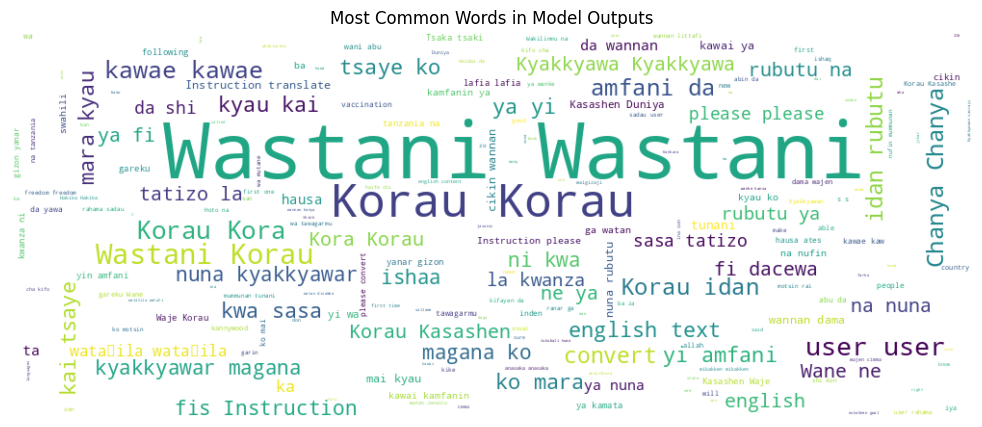

In [ ]:
from wordcloud import WordCloud

text = " ".join(results_df["generated"].dropna())
wordcloud = WordCloud(width=1000, height=400, background_color="white").generate(text)

plt.figure(figsize=(15, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Model Outputs")
plt.show()



In [ ]:
results_df["generated"].sample(10).tolist()



['Wastani Wastani Wastani Wastani Wastani Wastani Wastani Wastani Wastani Wastani',
 '0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0',
 'Korau Korau Korau Korau Korau Korau Kora',
 '1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2',
 '1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1',
 'Wastani Wastani Wastani Wastani Wastani Wastani Wastani Wastani Wastani Wastani',
 'Korau: idan ba a yi wa kowa adalci ba, to a yi wa kowa adalci.',
 'Wastani Wastani Wastani Wastani Wastani Wastani Wastani Wastani Wastani Wastani',
 'Wastani Wastani Wastani Wastani Wastani Wastani Wastani Wastani Wastani Wastani',
 '0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0']

**5. Instruction echo detection**
- prompt leakage/confusion


In [ ]:
echoed_instructions = results_df[results_df["generated"].str.contains("Instruction", na=False)]
echoed_instructions[["task", "inputs", "generated"]].sample(5)



,task,inputs,generated
592,mt,i voted on the first day,i voted on the first dayevansiagawa. ### Instr...
301,mt,"i agreed to.""","i agreed to.""ishaq(r)nasiha.fis Instruction: t..."
349,mt,"when all human beings are good, there is no bl...",Wane ne ya fi dacewa a gareku?fis Instruction:...
492,mt,before the war yesterday.,Wane ne ya fi dacewa a cikin wannan littafi?fi...
378,mt,the fact that a person has held office as gove...,anyone who is not a good news?fis Instruction:...
